<a href="https://colab.research.google.com/github/pranathi1997/TextClassification/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Classification

### Connecting to Drive Disk
For mounting the dataset and meta data generated from previous executions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
ROOT = '/content/drive/MyDrive/College/CSCE 5222 - Feature Engineering/ICA 1'
os.chdir(ROOT)
assert os.getcwd() == ROOT

### Installing necessary Libraries

In [ ]:
!pip install -q altair

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import io
import re
from pprint import pprint

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

## Setting seed and important constants
This solves the issue of randomness in training models

In [ ]:
seed = 42 
np.random.seed(seed)

## File Names

In [ ]:
log_files_fn = "log_files"

final_dataset_fn = "log_files/final_dataset.pickle"
X_train_fn = "log_files/X_train.pickle"
X_test_fn = "log_files/X_test.pickle"
y_train_fn = "log_files/y_train.pickle"
y_test_fn = "log_files/y_test.pickle"
df_fn = "log_files/df.pickle"
features_train_fn = "log_files/features_train.pickle"
labels_train_fn = "log_files/labels_train.pickle"
features_test_fn = "log_files/features_test.pickle"
labels_test_fn = "log_files/labels_test.pickle"
tfidf_fn = "log_files/tfidf.pickle"

results_fn = "results"
trained_models_fn = "trained_models"

random_forest_results_fn = "results/random_forest.pickle"
random_forest_model_fn = "trained_models/random_forest.pickle"

svm_results_fn = "results/svm.pickle"
svm_model_fn = "trained_models/svm.pickle"

knn_results_fn = "results/knn.pickle"
knn_model_fn = "trained_models/knn.pickle"

multinomial_naive_bayes_results_fn = "results/multinomial_naive_bayes.pickle"
multinomial_naive_bayes_model_fn = "trained_models/multinomial_naive_bayes.pickle"

multinomial_logistic_regression_results_fn = "results/multinomial_logistic_regression.pickle"
multinomial_logistic_regression_model_fn = "trained_models/multinomial_logistic_regression.pickle"

gradient_boosting_machine_results_fn = "results/gradient_boosting_machine.pickle"
gradient_boosting_machine_model_fn = "trained_models/gradient_boosting_machine.pickle"

## Helper Modules

In [ ]:
def check_directory_exists(filename):
  if os.path.isdir(filename):
    pass
  else:
    os.mkdir(filename)

## Loading dataset

In [ ]:
df = pd.read_csv('final_dataset.csv')

In [ ]:
df.head()

,title,media,date,datetime,desc,link,img,Category
0,Facebook Apologizes For Embarrassing Mistake C...,Forbes,1 hour ago,2021-09-04 20:13:47.921623,"Last week at the Paralympics in Tokyo, Toyota ...",https://www.forbes.com/sites/edwardsegal/2021/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles
1,EVs In 60ish Seconds: This Week's Interesting ...,InsideEVs,3 hours ago,2021-09-04 18:13:47.923740,... on helping electric and autonomous vehicle...,https://insideevs.com/news/530973/electric-car...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles
2,Why Cupertino Could Get Its Act Together With ...,Benzinga,4 hours ago,2021-09-04 17:13:47.925727,"Apple, Inc. (NASDAQ:AAPL) Car rumors resurface...",https://www.benzinga.com/analyst-ratings/analy...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles
3,This Is Why Tesla Is Offering Its Self-Driving...,HotCars,6 hours ago,2021-09-04 15:13:47.927648,Tesla has always been miles ahead of the compe...,https://www.hotcars.com/this-is-why-tesla-is-o...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles
4,Expo 2020 Dubai to drive the future of transport,Khaleej Times,6 hours ago,2021-09-04 15:13:47.929540,The Expo will be shaping and driving future mo...,https://www.khaleejtimes.com/uae/expo-2020-dub...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles


# Exploratory Data Analysis

## Number of articles in each category

In [ ]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X("Category"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
    tooltip=[alt.Tooltip('count()', title='Number of articles'), 'Category'],
    color='Category'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)

alt.LayerChart(...)

## % of articles in each category

In [ ]:
df['id'] = 1
df2 = pd.DataFrame(df.groupby('Category').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Category'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='Category'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each category",
)

alt.LayerChart(...)

The classes are approximately balanced. We'll first try to train the models without oversampling/undersampling. If we see some bias in the model, we'll use these techniques.

## Title length by category

Definition of news length field. Although there are special characters in the text (``\r, \n``), it will be useful as an approximation.

In [ ]:
df['Title_length'] = df['title'].str.len()

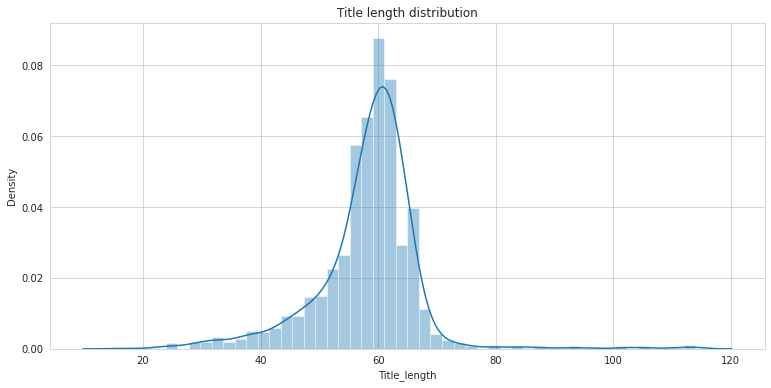

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['Title_length']).set_title('Title length distribution');

In [ ]:
df['Title_length'].describe()

count    1502.000000
mean       58.246338
std         8.997848
min        16.000000
25%        56.000000
50%        60.000000
75%        63.000000
max       114.000000
Name: Title_length, dtype: float64

Let's remove from the 95% percentile onwards to better appreciate the histogram:

In [ ]:
quantile_95 = df['Title_length'].quantile(0.95)
df_95 = df[df['Title_length'] < quantile_95]

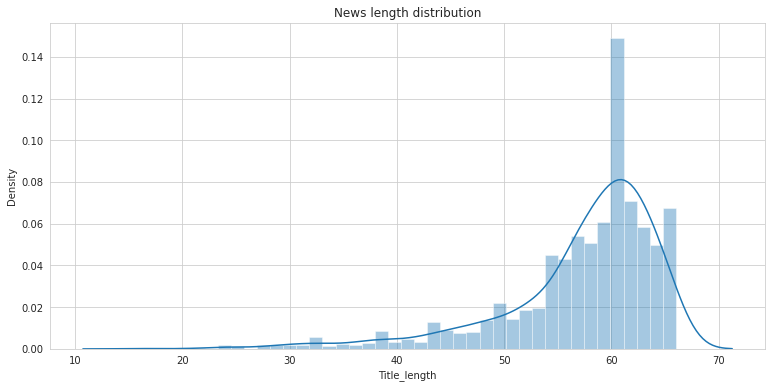

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['Title_length']).set_title('News length distribution');

We can get the number of news articles with more than 10,000 characters:

In [ ]:
df_more10k = df[df['Title_length'] > 100]
len(df_more10k)

9

Let's see one:

In [ ]:
df_more10k['title'].iloc[0]

'NSW Covid lockdown restrictions: update to Sydney, regional NSW and Canberra, ACT coronavirus rules explained'

It's just a large news article.

Let's now plot a boxplot:

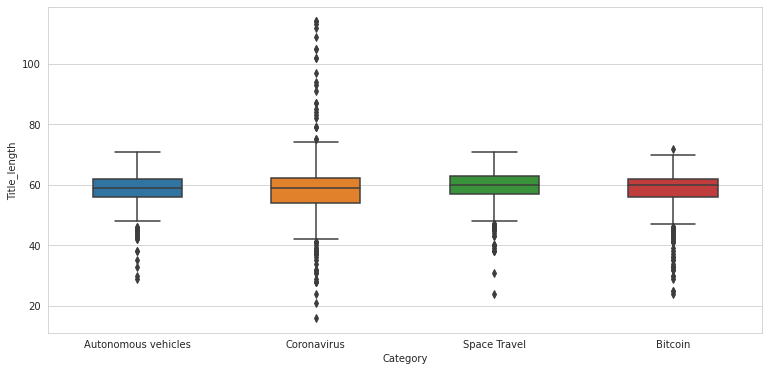

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Category', y='Title_length', width=.5);

Now, let's remove the larger documents for better comprehension:

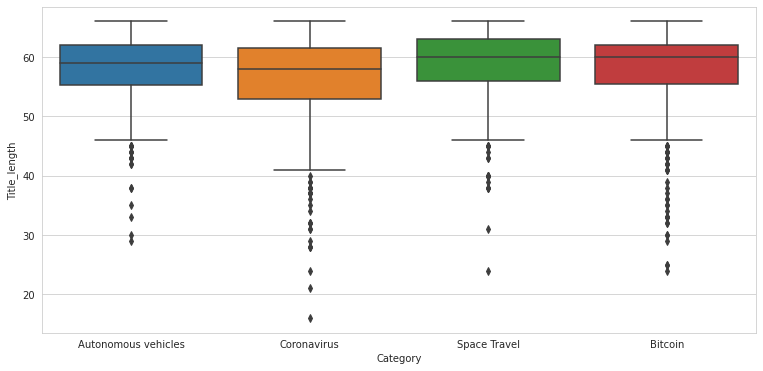

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Category', y='Title_length');

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

We'll save the dataset:

In [ ]:
check_directory_exists(log_files_fn)
with open(final_dataset_fn, 'wb') as output:
    pickle.dump(df, output)

# Feature Engineering

The next step is to create features from the raw text so we can train the machine learning models. The steps followed are:

1. **Text Cleaning and Preparation**: cleaning of special characters, downcasing, punctuation signs. possessive pronouns and stop words removal and lemmatization. 
2. **Label coding**: creation of a dictionary to map each category to a code.
3. **Train-test split**: to test the models on unseen data.
4. **Text representation**: use of TF-IDF scores to represent text.

First of all we'll load the dataset:

In [ ]:
check_directory_exists(log_files_fn)
with open(final_dataset_fn, 'rb') as data:
    df = pickle.load(data)

In [ ]:
df.head()

,title,media,date,datetime,desc,link,img,Category,id,Title_length
0,Facebook Apologizes For Embarrassing Mistake C...,Forbes,1 hour ago,2021-09-04 20:13:47.921623,"Last week at the Paralympics in Tokyo, Toyota ...",https://www.forbes.com/sites/edwardsegal/2021/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,57
1,EVs In 60ish Seconds: This Week's Interesting ...,InsideEVs,3 hours ago,2021-09-04 18:13:47.923740,... on helping electric and autonomous vehicle...,https://insideevs.com/news/530973/electric-car...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,57
2,Why Cupertino Could Get Its Act Together With ...,Benzinga,4 hours ago,2021-09-04 17:13:47.925727,"Apple, Inc. (NASDAQ:AAPL) Car rumors resurface...",https://www.benzinga.com/analyst-ratings/analy...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,64
3,This Is Why Tesla Is Offering Its Self-Driving...,HotCars,6 hours ago,2021-09-04 15:13:47.927648,Tesla has always been miles ahead of the compe...,https://www.hotcars.com/this-is-why-tesla-is-o...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,61
4,Expo 2020 Dubai to drive the future of transport,Khaleej Times,6 hours ago,2021-09-04 15:13:47.929540,The Expo will be shaping and driving future mo...,https://www.khaleejtimes.com/uae/expo-2020-dub...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,48


And visualize one sample news content:

In [ ]:
df.loc[1]['title']

"EVs In 60ish Seconds: This Week's Interesting EV News ..."

## 1 . Text cleaning and preparation

### 1.1. Special character cleaning

We can see the following special characters:

* ``\r``
* ``\n``
* ``\`` before possessive pronouns (`government's = government\'s`)
* ``\`` before possessive pronouns 2 (`Yukos'` = `Yukos\'`)
* ``"`` when quoting text

In [ ]:
df['Content_Parsed_1'] = df['title'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")

Regarding 3rd and 4th bullet, although it seems there is a special character, it won't affect us since it is not a *real* character:

In [ ]:
text = "Mr Greenspan\'s"
text

"Mr Greenspan's"

In [ ]:
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')

### 1.2. Upcase/downcase

We'll downcase the texts because we want, for example, `Football` and `football` to be the same word.

In [ ]:
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()

### 1.3. Punctuation signs

Punctuation signs won't have any predicting power, so we'll just get rid of them.

In [ ]:
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')

By doing this we are messing up with some numbers, but it's no problem since we aren't expecting any predicting power from them.

### 1.4. Possessive pronouns

We'll also remove possessive pronoun terminations:

In [ ]:
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")

### 1.5. Stemming and Lemmatization

Since stemming can produce output words that don't exist, we'll only use a lemmatization process at this moment. Lemmatization takes into consideration the morphological analysis of the words and returns words that do exist, so it will be more useful for us.

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In order to lemmatize, we have to iterate through every word:

In [ ]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [ ]:
df['Content_Parsed_5'] = lemmatized_text_list

Although lemmatization doesn't work perfectly in all cases (as can be seen in the example below), it can be useful.

### 1.6. Stop words

In [ ]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

In [ ]:
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

To remove the stop words, we'll handle a regular expression only detecting whole words, as seen in the following example:

In [ ]:
example = "me eating a meal"
word = "me"

# The regular expression is:
regex = r"\b" + word + r"\b"  # we need to build it like that to work properly

re.sub(regex, "StopWord", example)

'StopWord eating a meal'

We can now loop through all the stop words:

In [ ]:
df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

We have some dobule/triple spaces between words because of the replacements. However, it's not a problem because we'll tokenize by the spaces later.

As an example, we'll show an original news article and its modifications throughout the process:

In [ ]:
df.loc[5]['title']

'Hyundai reveals Ioniq 5-based robotaxi'

1. Special character cleaning

In [ ]:
df.loc[5]['Content_Parsed_1']

'Hyundai reveals Ioniq 5-based robotaxi'

2. Upcase/downcase

In [ ]:
df.loc[5]['Content_Parsed_2']

'hyundai reveals ioniq 5-based robotaxi'

3. Punctuation signs

In [ ]:
df.loc[5]['Content_Parsed_3']

'hyundai reveals ioniq 5-based robotaxi'

4. Possessive pronouns

In [ ]:
df.loc[5]['Content_Parsed_4']

'hyundai reveals ioniq 5-based robotaxi'

5. Stemming and Lemmatization

In [ ]:
df.loc[5]['Content_Parsed_5']

'hyundai reveal ioniq 5-based robotaxi'

6. Stop words

In [ ]:
df.loc[5]['Content_Parsed_6']

'hyundai reveal ioniq 5-based robotaxi'

Finally, we can delete the intermediate columns:

In [ ]:
df.head(1)

,title,media,date,datetime,desc,link,img,Category,id,Title_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
0,Facebook Apologizes For Embarrassing Mistake C...,Forbes,1 hour ago,2021-09-04 20:13:47.921623,"Last week at the Paralympics in Tokyo, Toyota ...",https://www.forbes.com/sites/edwardsegal/2021/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,57,Facebook Apologizes For Embarrassing Mistake C...,facebook apologizes for embarrassing mistake c...,facebook apologizes for embarrassing mistake c...,facebook apologizes for embarrassing mistake c...,facebook apologize for embarrass mistake cause...,facebook apologize embarrass mistake cause ai


In [ ]:
list_columns = df[["title", "media", "date", "datetime", "Content_Parsed_6", "Category"]]
list_columns = list_columns.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

In [ ]:
list_columns.head()

,title,media,date,datetime,Content_Parsed,Category
0,Facebook Apologizes For Embarrassing Mistake C...,Forbes,1 hour ago,2021-09-04 20:13:47.921623,facebook apologize embarrass mistake cause ai,Autonomous vehicles
1,EVs In 60ish Seconds: This Week's Interesting ...,InsideEVs,3 hours ago,2021-09-04 18:13:47.923740,evs 60ish second week interest ev news,Autonomous vehicles
2,Why Cupertino Could Get Its Act Together With ...,Benzinga,4 hours ago,2021-09-04 17:13:47.925727,cupertino could get act together 'apple car,Autonomous vehicles
3,This Is Why Tesla Is Offering Its Self-Driving...,HotCars,6 hours ago,2021-09-04 15:13:47.927648,tesla offer self-driving tech rival,Autonomous vehicles
4,Expo 2020 Dubai to drive the future of transport,Khaleej Times,6 hours ago,2021-09-04 15:13:47.929540,expo 2020 dubai drive future transport,Autonomous vehicles


**IMPORTANT:**

We need to remember that our model will gather the latest news articles from different newspapers every time we want. For that reason, we not only need to take into account the peculiarities of the training set articles, but also possible ones that are present in the gathered news articles.


## 2 . Label coding

We'll create a dictionary with the label codification:

In [ ]:
category_codes = {
    'Autonomous vehicles': 0,
    'Coronavirus': 1,
    'Space Travel': 2,
    'Bitcoin': 3,
}

In [ ]:
# Category mapping
df['Category_Code'] = list_columns['Category']
df = df.replace({'Category_Code':category_codes})

In [ ]:
df.head()

,title,media,date,datetime,desc,link,img,Category,id,Title_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6,Category_Code
0,Facebook Apologizes For Embarrassing Mistake C...,Forbes,1 hour ago,2021-09-04 20:13:47.921623,"Last week at the Paralympics in Tokyo, Toyota ...",https://www.forbes.com/sites/edwardsegal/2021/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,57,Facebook Apologizes For Embarrassing Mistake C...,facebook apologizes for embarrassing mistake c...,facebook apologizes for embarrassing mistake c...,facebook apologizes for embarrassing mistake c...,facebook apologize for embarrass mistake cause...,facebook apologize embarrass mistake cause ai,0
1,EVs In 60ish Seconds: This Week's Interesting ...,InsideEVs,3 hours ago,2021-09-04 18:13:47.923740,... on helping electric and autonomous vehicle...,https://insideevs.com/news/530973/electric-car...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,57,EVs In 60ish Seconds: This Week's Interesting ...,evs in 60ish seconds: this week's interesting ...,evs in 60ish seconds this week's interesting e...,evs in 60ish seconds this week interesting ev ...,evs in 60ish second this week interest ev news,evs 60ish second week interest ev news,0
2,Why Cupertino Could Get Its Act Together With ...,Benzinga,4 hours ago,2021-09-04 17:13:47.925727,"Apple, Inc. (NASDAQ:AAPL) Car rumors resurface...",https://www.benzinga.com/analyst-ratings/analy...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,64,Why Cupertino Could Get Its Act Together With ...,why cupertino could get its act together with ...,why cupertino could get its act together with ...,why cupertino could get its act together with ...,why cupertino could get its act together with ...,cupertino could get act together 'apple car,0
3,This Is Why Tesla Is Offering Its Self-Driving...,HotCars,6 hours ago,2021-09-04 15:13:47.927648,Tesla has always been miles ahead of the compe...,https://www.hotcars.com/this-is-why-tesla-is-o...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,61,This Is Why Tesla Is Offering Its Self-Driving...,this is why tesla is offering its self-driving...,this is why tesla is offering its self-driving...,this is why tesla is offering its self-driving...,this be why tesla be offer its self-driving te...,tesla offer self-driving tech rival,0
4,Expo 2020 Dubai to drive the future of transport,Khaleej Times,6 hours ago,2021-09-04 15:13:47.929540,The Expo will be shaping and driving future mo...,https://www.khaleejtimes.com/uae/expo-2020-dub...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",Autonomous vehicles,1,48,Expo 2020 Dubai to drive the future of transport,expo 2020 dubai to drive the future of transport,expo 2020 dubai to drive the future of transport,expo 2020 dubai to drive the future of transport,expo 2020 dubai to drive the future of transport,expo 2020 dubai drive future transport,0


## 3 . Train - test split

We'll set apart a test set to prove the quality of our models. We'll do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

Since we don't have much observations (only 2.225), we'll choose a test set size of 15% of the full dataset.

## 4 . Text representation

We have various options:

* Count Vectors as features
* TF-IDF Vectors as features
* Word Embeddings as features
* Text / NLP based features
* Topic Models as features

We'll use **TF-IDF Vectors** as features.

We have to define the different parameters:

* `ngram_range`: We want to consider both unigrams and bigrams.
* `max_df`: When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold
* `min_df`: When building the vocabulary ignore terms that have a document
    frequency strictly lower than the given threshold.
* `max_features`: If not None, build a vocabulary that only consider the top
    max_features ordered by term frequency across the corpus.

See `TfidfVectorizer?` for further detail.

It needs to be mentioned that we are implicitly scaling our data when representing it as TF-IDF features with the argument `norm`.

In [ ]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

We have chosen these values as a first approximation. Since the models that we develop later have a very good predictive power, we'll stick to these values. But it has to be mentioned that different combinations could be tried in order to improve even more the accuracy of the models.

In [ ]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1276, 198)
(226, 198)


Please note that we have fitted and then transformed the training set, but we have **only transformed** the **test set**.

We can use the Chi squared test in order to see what unigrams and bigrams are most correlated with each category:

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")


# 'Autonomous vehicles' category:
  . Most correlated unigrams:
. Self
. Driving
. driving
. Autonomous
. autonomous
  . Most correlated bigrams:
. Self Driving
. self driving

# 'Bitcoin' category:
  . Most correlated unigrams:
. BTC
. Cryptocurrency
. Crypto
. bitcoin
. Bitcoin
  . Most correlated bigrams:
. Bitcoin BTC
. TA Bitcoin

# 'Coronavirus' category:
  . Most correlated unigrams:
. Covid
. 19
. COVID
. coronavirus
. Coronavirus
  . Most correlated bigrams:
. Coronavirus COVID
. COVID 19

# 'Space Travel' category:
  . Most correlated unigrams:
. Blue
. Jeff
. Bezos
. Space
. space
  . Most correlated bigrams:
. Blue Origin
. Jeff Bezos



As we can see, the unigrams correspond well to their category. However, bigrams do not. If we get the bigrams in our features:

In [ ]:
bigrams

['for the',
 'Elon Musk',
 'as it',
 'FDA Authorizes',
 'it happened',
 'Covid 19',
 'El Salvador',
 'Why BTC',
 'Autonomous Vehicle',
 'driving car',
 'Bitcoin Price',
 'Bitcoin price',
 'Update FDA',
 'Bitcoin BTC',
 'Driving Cars',
 'autonomous driving',
 'Self driving',
 'the Coronavirus',
 'Autonomous Vehicles',
 'Autonomous Driving',
 '19 Update',
 'TA Bitcoin',
 'driving cars',
 'autonomous vehicles',
 'autonomous vehicle',
 'How to',
 'Coronavirus COVID',
 'to the',
 'Self Driving',
 'self driving',
 'COVID 19',
 'to Space',
 'Bezos space',
 'Bezos and',
 'Bezos Blue',
 'space travel',
 'Space Flight',
 'Space Travel',
 'space flight',
 'to space',
 'Richard Branson',
 'Virgin Galactic',
 'Blue Origin',
 'Jeff Bezos']

We can see there are only six. This means the unigrams have more correlation with the category than the bigrams, and since we're restricting the number of features to the most representative 300, only a few bigrams are being considered.

Let's save the files we'll need in the next steps:

In [ ]:
check_directory_exists(log_files_fn)

# X_train
with open(X_train_fn, 'wb') as output:
    pickle.dump(X_train, output)

# X_test    
with open(X_test_fn, 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open(y_train_fn, 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open(y_test_fn, 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open(df_fn, 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open(features_train_fn, 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open(labels_train_fn, 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open(features_test_fn, 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open(labels_test_fn, 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open(tfidf_fn, 'wb') as output:
    pickle.dump(tfidf, output)

# Model Training

Once we have our feature vectors built, we'll try several machine learning classification models in order to find which one performs best on our data. We will try with the following models:

* Baseline Classifier
* Random Forest
* Support Vector Machine
* K Nearest Neighbors
* Multinomial Naïve Bayes
* Multinomial Logistic Regression
* Gradient Boosting

The methodology used to train each model is as follows:

1. First of all, we'll decide which hyperparameters we want to tune.
2. Secondly, we'll define the metric we'll get when measuring the performance of a model. In this case, we'll use the **accuracy**.
3. We'll perform a Randomized Search Cross Validation process in order to find the hyperparameter region in which we get higher values of accuracy. 
4. Once we find that region, we'll use a Grid Search Cross Validation process to exhaustively find the best combination of hyperparameters.
5. Once we obtain the best combination of hyperparameters, we'll obtain the accuracy on the training data and the test data, the classification report and the confusion matrix.
6. Finally, we'll calculate the accuracy of a model with default hyperparameters, to see if we have achieved better results by hyperparameter tuning.

We need to be aware of the fact that our dataset only contains 4 categories:

* Autonomous vehicles
* Coronavirus
* Space Travel
* Bitcoin

So, when we get news articles that don't belong to any of that categories (for example, weather or terrorism news articles), we will surely get a wrong prediction. For this reason we will take into account the conditional probability of belonging to every class and set a lower threshold (i.e. if the 4 conditional probabilities are lower than 65% then the prediction will be 'other'). This probability vector can be obtained in a simple way in some models, but not in other ones. For this reason we will take this into consideration when choosing the model to use.

# Loading Data

First, we load the data:

In [ ]:
check_directory_exists(log_files_fn)

# Dataframe
with open(df_fn, 'rb') as data:
    df = pickle.load(data)

# features_train
with open(features_train_fn, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
with open(labels_train_fn, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
with open(features_test_fn, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
with open(labels_test_fn, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [ ]:
print(features_train.shape)
print(features_test.shape)

(1276, 198)
(226, 198)


# Random Forest

## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [ ]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `n_estimators` = number of trees in the forest.
* `max_features` = max number of features considered for splitting a node
* `max_depth` = max number of levels in each decision tree
* `min_samples_split` = min number of data points placed in a node before the node is split
* `min_samples_leaf` = min number of data points allowed in a leaf node
* `bootstrap` = method for sampling data points (with or without replacement)

### Randomized Search Cross Validation

We first need to define the grid:

In [ ]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


Then, we'll perform the Random Search:

In [ ]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

We can see the best hyperparameters resulting from the Random Search:

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9302457884562276


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [ ]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  2.5min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sampl...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=8,
                                  

The best hyperparameters turn out to be:

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.9352290679304898


Let's save the model in `best_rfc`:

In [ ]:
best_rfc = grid_search.best_estimator_

In [ ]:
best_rfc

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

We now know the best random forest model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [ ]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

And get the predictions:

In [ ]:
rfc_pred = best_rfc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`rfc_pred = best_rfc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [ ]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.9843260188087775


#### Test accuracy

In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.9380530973451328


#### Classification report

In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        56
           1       0.86      0.95      0.90        62
           2       0.98      0.92      0.95        50
           3       0.98      0.93      0.96        58

    accuracy                           0.94       226
   macro avg       0.94      0.94      0.94       226
weighted avg       0.94      0.94      0.94       226



#### Confusion matrix

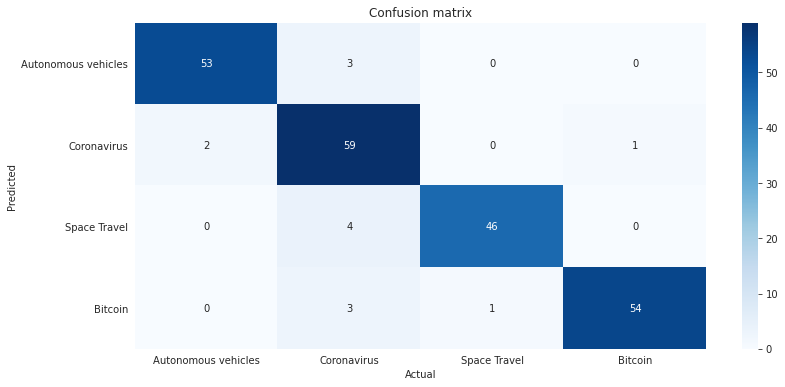

In [ ]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [ ]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9292035398230089

In [ ]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.9380530973451328

We'll create a dataset with a model summary to compare models:

In [ ]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [ ]:
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.984326,0.938053


Let's save the model and this dataset:

In [ ]:
check_directory_exists(trained_models_fn)
with open(random_forest_model_fn, 'wb') as output:
    pickle.dump(best_rfc, output)

check_directory_exists(results_fn)
with open(random_forest_results_fn, 'wb') as output:
    pickle.dump(df_models_rfc, output)

# Support Vector Machine

## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [ ]:
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


We'll tune the following ones:

* `C`: Penalty parameter C of the error term.
* `kernel`: Specifies the kernel type to be used in the algorithm.
* `gamma`: Kernel coefficient.
* `degree`: Degree of the polynomial kernel function.


### Randomized Search Cross Validation

We first need to define the grid:

In [ ]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


Then, we'll perform the Random Search:

In [ ]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=8,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random_s

We can see the best hyperparameters resulting from the Random Search:

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.7649065635643929


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [ ]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  2.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=8, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated'...one,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability':

The best hyperparameters turn out to be:

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.914691943127962


Let's save the model in `best_svc`:

In [ ]:
best_svc = grid_search.best_estimator_

In [ ]:
best_svc

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

We now know the best SVM model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [ ]:
best_svc.fit(features_train, labels_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

And get the predictions:

In [ ]:
svc_pred = best_svc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`svc_pred = best_svc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [ ]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.9443573667711599


#### Test accuracy

In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.9380530973451328


#### Classification report

In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        56
           1       0.86      0.95      0.90        62
           2       1.00      0.90      0.95        50
           3       1.00      0.95      0.97        58

    accuracy                           0.94       226
   macro avg       0.95      0.94      0.94       226
weighted avg       0.94      0.94      0.94       226



#### Confusion matrix

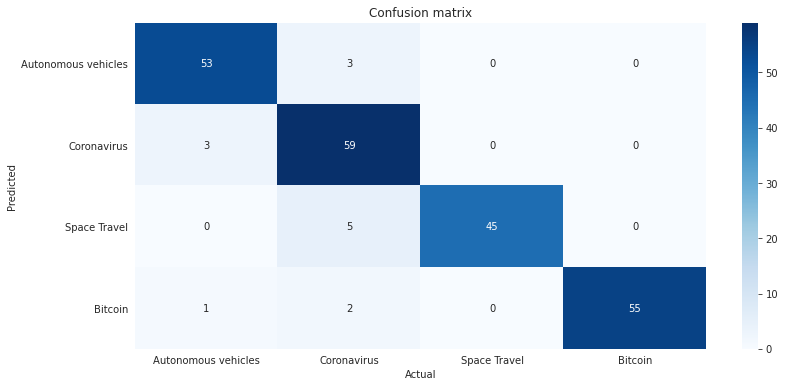

In [ ]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [ ]:
base_model = svm.SVC(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9292035398230089

In [ ]:
best_svc.fit(features_train, labels_train)
accuracy_score(labels_test, best_svc.predict(features_test))

0.9380530973451328

We'll create a dataset with a model summary to compare models:

In [ ]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])

In [ ]:
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.944357,0.938053


Let's save the model and this dataset:

In [ ]:
check_directory_exists(trained_models_fn)
with open(svm_model_fn, 'wb') as output:
    pickle.dump(best_svc, output)
    
check_directory_exists(results_fn)
with open(svm_results_fn, 'wb') as output:
    pickle.dump(df_models_svc, output)

# K Nearest Neighbors

## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [ ]:
knnc_0 =KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


We'll tune the following ones:

* `K`: Number of neighbors to use by default for queries.

In this case, since there is only one hyperparameter, we'll perform an exhaustive search directly:

### Grid Search Cross Validation

We first need to define the grid:

In [ ]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   49.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                         51, 56, 61, 66, 71, 76, 81, 86, 91, 96,
                                         101, 106, 111, 116, 121, 127, 132, 137,
                                         142, 147, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

The best parameters turn out to be:

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 51}

The mean accuracy of a model with these hyperparameters is:
0.9202211690363349


Since the grid had a space of 5 between each element, we'll now cover all the possible `n_neighbors` near to 6:

In [ ]:
n_neighbors = [1,2,3,4,5,6,7,8,9,10,11]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    5.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

The best parameters turn out to be:

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 11}

The mean accuracy of a model with these hyperparameters is:
0.8412322274881516


Let's save the model in `best_knnc`:

In [ ]:
best_knnc = grid_search.best_estimator_

In [ ]:
best_knnc

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

We now know the best KNN model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [ ]:
best_knnc.fit(features_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

And get the predictions:

In [ ]:
knnc_pred = best_knnc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`knnc_pred = best_knnc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [ ]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

The training accuracy is: 
0.8934169278996865


#### Test accuracy

In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.8584070796460177


#### Classification report

In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.92      0.84      0.88        56
           1       0.77      0.95      0.85        62
           2       0.93      0.80      0.86        50
           3       0.87      0.83      0.85        58

    accuracy                           0.86       226
   macro avg       0.87      0.85      0.86       226
weighted avg       0.87      0.86      0.86       226



#### Confusion matrix

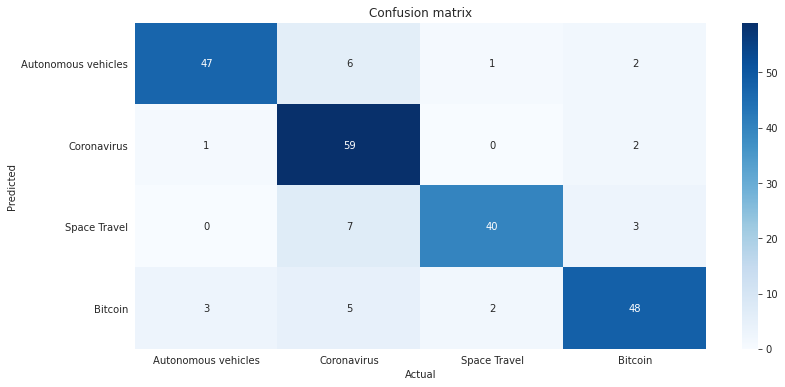

In [ ]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, knnc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [ ]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.8539823008849557

In [ ]:
best_knnc.fit(features_train, labels_train)
accuracy_score(labels_test, best_knnc.predict(features_test))

0.8584070796460177

We can see that the default model (with 5 Nearest Neighbors) performs better. However, in our Grid Search Cross Validation process we tried with that number of neighbors. The reason why we may be getting this result is because de Grid Search performs a Cross Validation scheme, while this last comparison uses all training data.

We'll create a dataset with a model summary to compare models:

In [ ]:
d = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(labels_train, best_knnc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, knnc_pred)
}

df_models_knnc = pd.DataFrame(d, index=[0])

In [ ]:
df_models_knnc

,Model,Training Set Accuracy,Test Set Accuracy
0,KNN,0.893417,0.858407


Let's save the model and this dataset:

In [ ]:
check_directory_exists(trained_models_fn)
with open(knn_model_fn, 'wb') as output:
    pickle.dump(best_knnc, output)

check_directory_exists(results_fn)
with open(knn_results_fn, 'wb') as output:
    pickle.dump(df_models_knnc, output)

# Multinomial Naïve Bayes

## Cross-Validation for Hyperparameter tuning

In the case of the Multinomial Naïve Bayes, we will not tune any hyperparameter.

In [ ]:
mnbc = MultinomialNB()
mnbc

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [ ]:
mnbc.fit(features_train, labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

And get the predictions:

In [ ]:
mnbc_pred = mnbc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`mnbc_pred = mnbc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [ ]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))

The training accuracy is: 
0.9435736677115988


#### Test accuracy

In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))

The test accuracy is: 
0.9380530973451328


#### Classification report

In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,mnbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        56
           1       0.91      0.95      0.93        62
           2       1.00      0.90      0.95        50
           3       0.92      0.97      0.94        58

    accuracy                           0.94       226
   macro avg       0.94      0.94      0.94       226
weighted avg       0.94      0.94      0.94       226



#### Confusion matrix

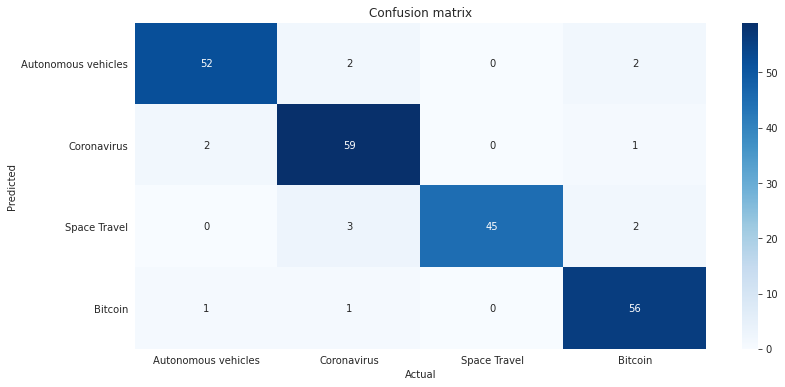

In [ ]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

We'll create a dataset with a model summary to compare models:

In [ ]:
d = {
     'Model': 'Multinomial Naïve Bayes',
     'Training Set Accuracy': accuracy_score(labels_train, mnbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, mnbc_pred)
}

df_models_mnbc = pd.DataFrame(d, index=[0])

In [ ]:
df_models_mnbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Multinomial Naïve Bayes,0.943574,0.938053


Let's save the model and this dataset:

In [ ]:
check_directory_exists(trained_models_fn)
with open(multinomial_naive_bayes_model_fn, 'wb') as output:
    pickle.dump(mnbc, output)

check_directory_exists(results_fn)  
with open(multinomial_naive_bayes_results_fn, 'wb') as output:
    pickle.dump(df_models_mnbc, output)

# Multinomial Logistic Regression

## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [ ]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `C` = Inverse of regularization strength. Smaller values specify stronger regularization.
* `multi_class` = We'll choose `multinomial` because this is a multi-class problem.
* `solver` = Algorithm to use in the optimization problem. For multiclass problems, only `newton-cg`, `sag`, `saga` and `lbfgs` handle multinomial loss.
* `class_weight`: Weights associated with classes. 
* `penalty`: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

### Randomized Search Cross Validation

We first need to define the grid:

In [ ]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


Then, we'll perform the Random Search:

In [ ]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   16.5s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=8,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanc

We can see the best hyperparameters resulting from the Random Search:

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.9341655159716469


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [ ]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0]

The best hyperparameters turn out to be:

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.8222222222222222, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9233807266982623


Let's save the model in `best_lrc`:

In [ ]:
best_lrc = grid_search.best_estimator_

In [ ]:
best_lrc

LogisticRegression(C=0.8222222222222222, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

We now know the best logistic regression model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [ ]:
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=0.8222222222222222, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

And get the predictions:

In [ ]:
lrc_pred = best_lrc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`lrc_pred = best_lrc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [ ]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.9647335423197492


#### Test accuracy

In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.9336283185840708


#### Classification report

In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        56
           1       0.89      0.94      0.91        62
           2       0.98      0.90      0.94        50
           3       0.95      0.95      0.95        58

    accuracy                           0.93       226
   macro avg       0.94      0.93      0.93       226
weighted avg       0.93      0.93      0.93       226



#### Confusion matrix

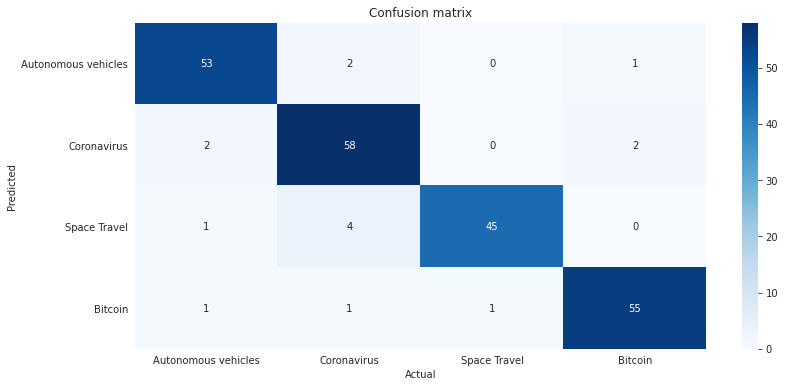

In [ ]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [ ]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9336283185840708

In [ ]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

0.9336283185840708

We get approximately the same accuracy.

We'll create a dataset with a model summary to compare models:

In [ ]:
d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])

In [ ]:
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,0.964734,0.933628


Let's save the model and this dataset:

In [ ]:
check_directory_exists(trained_models_fn)
with open(multinomial_logistic_regression_model_fn, 'wb') as output:
    pickle.dump(best_lrc, output)

check_directory_exists(results_fn)  
with open(multinomial_logistic_regression_results_fn, 'wb') as output:
    pickle.dump(df_models_lrc, output)

# Gradient Boosting Machine

References: 

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [ ]:
gb_0 = GradientBoostingClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(gb_0.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

Tree-related hyperparameters:
* `n_estimators` = number of trees in the forest.
* `max_features` = max number of features considered for splitting a node
* `max_depth` = max number of levels in each decision tree
* `min_samples_split` = min number of data points placed in a node before the node is split
* `min_samples_leaf` = min number of data points allowed in a leaf node

Boosting-related hyperparameters:
* `learning_rate`= learning rate shrinks the contribution of each tree by learning_rate.
* `subsample`= the fraction of samples to be used for fitting the individual base learners.

### Randomized Search Cross Validation

We first need to define the grid. Since we have a huge amount of hyperparameters, we'll try few values for each one.

In [ ]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


Then, we'll perform the Random Search:

In [ ]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 37.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

We can see the best hyperparameters resulting from the Random Search:

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.929463315842769


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [ ]:
# Create the parameter grid based on the results of random search 
max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.5min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samp...
                                                  tol=0.0001,
                                                  validation_fraction=0.1,
                 

The best hyperparameters turn out to be:

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 50, 'n_estimators': 800, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.9202211690363349


Let's save the model in `best_gbc`:

In [ ]:
best_gbc = grid_search.best_estimator_

In [ ]:
best_gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

We now know the best gradient boosting model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [ ]:
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

And get the predictions:

In [ ]:
gbc_pred = best_gbc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`gbc_pred = best_gbc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [ ]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

The training accuracy is: 
0.9882445141065831


#### Test accuracy

In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, gbc_pred))

The test accuracy is: 
0.9424778761061947


#### Classification report

In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96        56
           1       0.90      0.92      0.91        62
           2       0.96      0.92      0.94        50
           3       0.97      0.97      0.97        58

    accuracy                           0.94       226
   macro avg       0.94      0.94      0.94       226
weighted avg       0.94      0.94      0.94       226



#### Confusion matrix

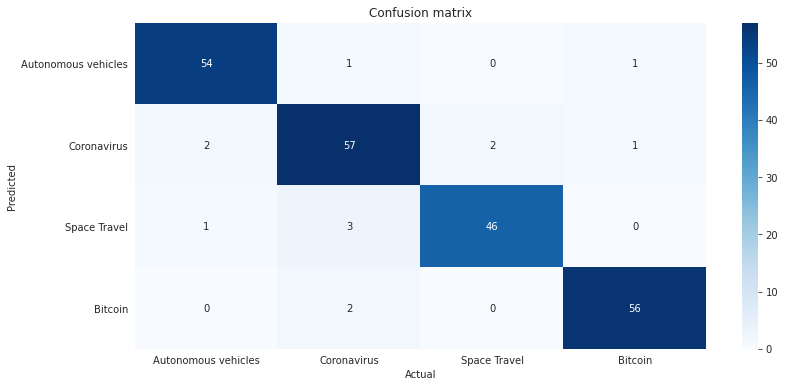

In [ ]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [ ]:
base_model = GradientBoostingClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9380530973451328

In [ ]:
best_gbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_gbc.predict(features_test))

0.9424778761061947

We'll create a dataset with a model summary to compare models:

In [ ]:
d = {
     'Model': 'Gradient Boosting',
     'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}

df_models_gbc = pd.DataFrame(d, index=[0])

In [ ]:
df_models_gbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,0.988245,0.942478


Let's save the model and this dataset:

In [ ]:
check_directory_exists(trained_models_fn)
with open(gradient_boosting_machine_model_fn, 'wb') as output:
    pickle.dump(best_gbc, output)

check_directory_exists(results_fn)   
with open(gradient_boosting_machine_results_fn, 'wb') as output:
    pickle.dump(df_models_gbc, output)

# Best Model Selection

Now that we have trained all the models, let's select the one we'll use for the application. We'll need to get the performance metrics generated in every model:

In [ ]:
path_pickles = "/home/lnc/0. Latest News Classifier/04. Model Training/Models/"

list_pickles = [
    "df_models_gbc.pickle",
    "df_models_knnc.pickle",
    "df_models_lrc.pickle",
    "df_models_mnbc.pickle",
    "df_models_rfc.pickle",
    "df_models_svc.pickle"
]

df_summary = pd.DataFrame()

for pickle_ in list_pickles:
    
    path = path_pickles + pickle_
    
    with open(path, 'rb') as data:
        df = pickle.load(data)

    df_summary = df_summary.append(df)

df_summary = df_summary.reset_index().drop('index', axis=1)

FileNotFoundError: ignored

Let's see the summary:

In [ ]:
df_summary

And sort it by **Test Set Accuracy**:

In [ ]:
df_summary.sort_values('Test Set Accuracy', ascending=False)

The Gradient Boosting, Logistic Regression and Random Forest seem to be overfit, so we'll discard them. From the remaining models, we will choose the **Support Vector Machine** since it has the highest Test Set Accuracy.

# Dimensionality Reduction Plots

We'll perform a dimensionality reduction technique to plot the observations in 2 dimensions.

We'll use two techniques:

* **Principal Component Analysis**: this technique relies on the obtention of the eigenvalues and eigenvectors of the data matrix and tries to provide a minimum number of variables that keep the maximum amount of variance.
* **t-SNE**: the t-distributed Stochastic Neighbour Embedding is a probabilistic technique particularly well suited for the visualization of high-dimensional datasets. It minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.





In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

Let's get the features and labels and plot them:

In [ ]:
# Dataframe
path_df = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

We'll unify training and test sets. The initial shapes are:

In [ ]:
print(features_train.shape)
print(features_test.shape)
print(labels_train.shape)
print(labels_test.shape)

Let's do the concatenation:

In [ ]:
features = np.concatenate((features_train,features_test), axis=0)
labels = np.concatenate((labels_train,labels_test), axis=0)

And check the shapes are correct:

In [ ]:
print(features.shape)
print(labels.shape)

We'll define a function that comprises the whole visualization process:

In [ ]:
def plot_dim_red(model, features, labels, n_components=2):
    
    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "PCA decomposition"  # for the plot
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=2)
        title = "t-SNE decomposition" 

    else:
        return "Error"
    
    # Fit and transform the features
    principal_components = mod.fit_transform(features)
    
    # Put them into a dataframe
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])
    
    # Now we have to paste each row's label and its meaning
    # Convert labels array to df
    df_labels = pd.DataFrame(data=labels,
                             columns=['label'])
    
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['label'].astype(str)

    # Get labels name
    category_names = {
        "0": 'business',
        "1": 'entertainment',
        "2": 'politics',
        "3": 'sport',
        "4": 'tech'
    }

    # And map labels
    df_full['label_name'] = df_full['label']
    df_full = df_full.replace({'label_name':category_names})

    # Plot
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue="label_name", 
                    data=df_full,
                    palette=["red", "pink", "royalblue", "greenyellow", "lightseagreen"],
                    alpha=.7).set_title(title);

## Dimensionality reduction with PCA

Let's plot the PCA model result:

In [ ]:
plot_dim_red("PCA", 
             features=features, 
             labels=labels,
             n_components=2)

## Dimensionality Reduction with t-SNE

Let's plot the t-SNE model result:

In [ ]:
plot_dim_red("TSNE", 
             features=features, 
             labels=labels,
             n_components=2)

We can see that the t-SNE decomposition works much better on our data.

<hr><font color="green"><h1>from file: 14. Model Interpretation</h1></font>

# Model Interpretation

At this point we have selected the SVM as our preferred model to do the predictions. We will now study its behaviour by analyzing misclassified articles. Hopefully this will give us some insights on the way the model is working.

In [ ]:
import pickle
import pandas as pd
import numpy as np
import random

Let's load what we need:

In [ ]:
# Dataframe
path_df = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)
    
# X_train
path_X_train = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/X_train.pickle"
with open(path_X_train, 'rb') as data:
    X_train = pickle.load(data)

# X_test
path_X_test = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/X_test.pickle"
with open(path_X_test, 'rb') as data:
    X_test = pickle.load(data)

# y_train
path_y_train = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/y_train.pickle"
with open(path_y_train, 'rb') as data:
    y_train = pickle.load(data)

# y_test
path_y_test = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/y_test.pickle"
with open(path_y_test, 'rb') as data:
    y_test = pickle.load(data)

# features_train
path_features_train = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)
    
# SVM Model
path_model = "/home/lnc/0. Latest News Classifier/04. Model Training/Models/best_svc.pickle"
with open(path_model, 'rb') as data:
    svc_model = pickle.load(data)
    
# Category mapping dictionary
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

category_names = {
    0: 'business',
    1: 'entertainment',
    2: 'politics',
    3: 'sport',
    4: 'tech'
}

Let's get the predictions on the test set:

In [ ]:
predictions = svc_model.predict(features_test)

Now we'll create the Test Set dataframe with the actual and predicted categories:

In [ ]:
# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['Prediction'] = predictions

# Clean columns
df_test = df_test[['Content', 'Category', 'Category_Code', 'Prediction']]

# Decode
df_test['Category_Predicted'] = df_test['Prediction']
df_test = df_test.replace({'Category_Predicted':category_names})

# Clean columns again
df_test = df_test[['Content', 'Category', 'Category_Predicted']]

In [ ]:
df_test.head()

Let's get the misclassified articles:

In [ ]:
condition = (df_test['Category'] != df_test['Category_Predicted'])

df_misclassified = df_test[condition]

df_misclassified.head(3)

Let's get a sample of 3 articles. We'll define a function to make this process faster:

In [ ]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['Category']))
    print('Predicted Category: %s' %(row_article['Category_Predicted']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['Content']))

We'll get three random numbers from the indexes:

In [ ]:
random.seed(8)
list_samples = random.sample(list(df_misclassified.index), 3)
list_samples

First case:

In [ ]:
output_article(df_misclassified.loc[list_samples[0]])

Second case:

In [ ]:
output_article(df_misclassified.loc[list_samples[1]])

Third case:

In [ ]:
output_article(df_misclassified.loc[list_samples[2]])

We can see that in all cases the category is not 100% clear, since these articles contain concepts of both categories. These errors will always happen and we are not looking forward to be 100% accurate on them.

<hr><font color="green"><h1>from file: 15. Sample Articles</h1></font>

# Sample Articles

We'll get some articles and predict their category to see how the model works on newly scraped data. These will allow further comprehension of the model and we will be able to determine a threshold to assign a given article to the category `other`.


We have to import:

* Trained models
* TF-IDF model

In [ ]:
import pickle
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import punkt
from nltk.corpus.reader import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

#### Trained models

In [ ]:
path_models = "/home/lnc/0. Latest News Classifier/04. Model Training/Models/"

# SVM
path_svm = path_models + 'best_svc.pickle'
with open(path_svm, 'rb') as data:
    svc_model = pickle.load(data)

#### TF-IDF object

In [ ]:
path_tfidf = "/home/lnc/0. Latest News Classifier/03. Feature Engineering/Pickles/tfidf.pickle"
with open(path_tfidf, 'rb') as data:
    tfidf = pickle.load(data)

#### Category mapping dictionary

In [ ]:
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

#### Feature engineering workflow

In [ ]:
punctuation_signs = list("?:!.,;")
stop_words = list(stopwords.words('english'))

def create_features_from_text(text):
    
    # Dataframe creation
    lemmatized_text_list = []
    df = pd.DataFrame(columns=['Content'])
    df.loc[0] = text
    df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')
    df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
    df['Content_Parsed_3'] = df['Content_Parsed_2']
    for punct_sign in punctuation_signs:
        df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')
    df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    text = df.loc[0]['Content_Parsed_4']
    text_words = text.split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)    
    lemmatized_text_list.append(lemmatized_text)
    df['Content_Parsed_5'] = lemmatized_text_list
    df['Content_Parsed_6'] = df['Content_Parsed_5']
    for stop_word in stop_words:
        regex_stopword = r"\b" + stop_word + r"\b"
        df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')
    df = df['Content_Parsed_6']
    df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})
    
    # TF-IDF
    features = tfidf.transform(df).toarray()
    
    return features

Now let's write a function that tells us the category given the category code:

In [ ]:
def get_category_name(category_id):
    for category, id_ in category_codes.items():    
        if id_ == category_id:
            return category

Finally, let's write a function that includes the whole process:

In [ ]:
def predict_from_text(text):
    
    # Predict using the input model
    prediction_svc = svc_model.predict(create_features_from_text(text))[0]
    prediction_svc_proba = svc_model.predict_proba(create_features_from_text(text))[0]
    
    # Return result
    category_svc = get_category_name(prediction_svc)
    
    print("The predicted category using the SVM model is %s." %(category_svc) )
    print("The conditional probability is: %a" %(prediction_svc_proba.max()*100))

### Text introduction and prediction

Please introduce `text`:

In [ ]:
text = """

The center-right party Ciudadanos closed a deal on Wednesday with the support of the conservative Popular Party (PP) to take control of the speaker’s committee in the Andalusian parliament, paving the way for the regional PP leader, Juan Manuel Moreno, to stand as the candidate for premier of the southern Spanish region. The move would see the Socialist Party (PSOE) lose power in the Junta, as the regional government is known, for the first time in 36 years.

Talks in Andalusia have been ongoing since regional polls were held on December 2. The PSOE, led by incumbent premier Susana Díaz, had been expected to win the early elections, but in a shock result the party took the most seats in parliament, 33, but fell well short of a majority of 55. It was their worst result in the region since Spain returned to democracy. The PP came in second, with 26 seats, while Ciudadanos were third with 21. The major surprise was the strong performance of far-right group Vox, which won more than 391,000 votes (10.9%), giving it 12 deputies. The anti-immigration group is the first of its kind to win seats in a Spanish parliament since the end of the Francisco Franco dictatorship. It now holds the key to power in Andalusia, given that its votes, added to those of the PP and Ciudadanos, constitute an absolute majority.

The move would see the Socialist Party lose power in the region for the first time in 36 years

On Thursday, Marta Bosquet of Ciudadanos was voted in as the new speaker of the Andalusian parliament thanks to 59 votes from her party, the PP and Vox. The other candidate, Inmaculada Nieto of Adelante Andalucía, secured 50 votes – from her own party and 33 from the PSOE.

The speaker’s role in the parliament is key for the calling of an investiture vote and for the selection of the candidate for premier.

Officially, the talks as to the make up of a future government have yet to start, but in reality they are well advanced, according to sources from both the PP and Ciudadanos. The leader of the Andalusian PP is banking on being voted into power around January 16 and wants the majority of his Cabinet to be decided “five days before the investiture vote.”

The speaker’s role in the parliament is key for the calling of an investiture vote and for the selection of the candidate for premier

The PP, which was ousted from power by the PSOE in the national government in June, is keen to take the reins of power in Andalusia as soon as possible. The difficulties that Ciudadanos has faced to justify the necessary inclusion of Vox in the talks, has slowed down progress. Rather than align itself with the far right party, the group – which began life in Catalonia in response to the independence drive, but soon launched onto the national stage – had sought a deal with Adelante Andalucía.

Wednesday was a day of intense talks among the parties in a bid to find a solution that would keep everyone happy. But at 9pm last night, Adelante Andalucía announced that it would not be part of “any deal” and that would instead vote for its own candidates to the speaker’s committee in order to “face up to the right wing and the extreme right.”

The PSOE, meanwhile, argues that having won the elections with a seven-seat lead over the PP gives it the legitimacy to aspire to the control of the regional government and the parliament, and to maintain its positions on the speaker’s committee.



"""

In [ ]:
predict_from_text(text)

## Threshold determination

We'll introduce some news articles text and see how the conditional probability vector behaves. Firstly we'll introduce articles that clearly belong to one of the five categories and then, we'll introduce articles that do not belong to neither of them.

### Articles that clearly belong to one of the five categories

In [ ]:
# Politics

text = """Disputes have already broken out within the new political alliance that is working to end 36 years of rule by the Socialist Party (PSOE) in Spain’s southern region of Andalusia.

Just hours after the far-right Vox agreed to support the Popular Party (PP)’s candidate to head the region, Juan Manuel Moreno, its demand for a specific regional department for family affairs is running into opposition from Ciudadanos (Citizens), the third party involved in the government change.

These early clashes suggest it could be difficult to export the model to other parts of Spain

The PP and the liberal Ciudadanos have reached their own governing agreement in the wake of an election that undermined the Socialists’ hold on power, but they need support from Vox’s 12 newly elected lawmakers to make it a reality.

Ciudadanos has refused point-blank to meet with Vox representatives, but the PP has struck its own parallel deal with the far right to ensure its support at the investiture debate, which will take place on January 15 and 16.

On Friday morning, Juan Marín of Ciudadanos said that there are no plans for a separate family affairs department within the government structure they have devised with their PP partners, and which does not include Vox.

The reform party has insisted that the Vox-PP deal does not affect them at all, and Ciudadanos’ national leader, Albert Rivera, said on Thursday that Vox “has had to take a step back, correct itself, and sheathe its sword,” alluding to the fact that Vox has dropped some of its most radical demands such as the deportation of 52,000 undocumented migrants.

 Vox national leader Santiago Abascal (c) and Andalusian leader Francisco Serrano (r).
Vox national leader Santiago Abascal (c) and Andalusian leader Francisco Serrano (r). REUTERS
But Vox insists on a family department, and said it will expect loyalty from the PP on this issue. Meanwhile, Ciudadanos has also warned it will not support the PP-Vox proposal to change the historical memory law for a “concord law.”

These early clashes suggest it could be difficult to export the model to other parts of Spain, where local and regional elections are scheduled to be held this year. The PP president, Pablo Casado, said on Thursday that their separate deals with Ciudadanos and Vox in Andalusia are “a preamble of what’s going to happen in May in Spain.”

The PP is anxious to win back power in regions like Valencia, the Balearic Islands, Castilla-La Mancha, Aragón and Cantabria, and to retain it in Madrid, Murcia, La Rioja and Castilla y León.

Parliamentary debate
The PSOE has already digested the fact that it is losing its hold on Spain’s most populated region. “We will conduct a responsible opposition, and remain vigilant about defending self-government and Andalusia’s presence in Spain,” said the party’s parliamentary spokesman, Mario Jiménez.

The Socialists will not be putting forward a candidate, now that the PP nominee has enough support for an absolute majority in the first round. The debates will take place on January 15 and 16, followed by a vote, said Speaker Marta Bosquet.

The sum of the PP, Ciudadanos and Vox votes is four above the 55 required for a majority. The PSOE lost 14 seats at the December 2 election, down to 33. The Podemos-backed Adelante Andalucía has 17 lawmakers.

"""

predict_from_text(text)

In [ ]:
# Entertainment

text = """
Cádiz is in style: it has just been included in The New York Times’ list of 52 Places to Go in 2019. The recognition comes on the back of acknowledgment from TripAdvisor, which last year ranked Cádiz eighth on its list of European Destinations On The Rise for 2018.

The journalist Andrew Ferren, who wrote about Cádiz for The New York Times’ list, lives in Spain himself and is no stranger to the southern province’s charms. “I am fascinated by its mix of atmospheres,” he says. “You leap from places as sophisticated and cultured as Jerez de la Frontera to wild landscapes that take your breath away, such as the beach in Bolonia or Alcornocales Park. It’s like the Wild West of southern of Spain.”

“Despite the fact that Cádiz was historically a major maritime link between America and Europe, it’s not very well known to the US public and it’s really worth a visit,” he adds. There are three main reasons why The New York Times recommends a trip to Cádiz:

Culinary delights
 Aponiente restaurant in El Puerto de Santa María.
Aponiente restaurant in El Puerto de Santa María.
Suggestions include the new Western-style gastrobar Saja River, recently opened on Santa Elena street, and Código de Barra in La Candelaria Square. Ferren also suggests crossing the bay from the capital to Puerto de Santa María, where Angel León has his three-starred Michelin restaurant offering “a lyrical poem of seafood.” Just 40 km from here, León has another restaurant within the Meliá Sancti Petri hotel called Alevante, which has just been awarded its first Michelin star. For something more casual, there is La Taberna del Chef del Mar, another of the chef’s brands in El Puerto.

To these suggestions, EL VIAJERO adds several of its own, including Restaurante Café Royalty, which opened opened in 1912, and the bookshop café La Clandestina (José del Toro, 23), which serves scrumptious breakfasts. There is also La Candela (Feduchy, 13) for tapas, while an exquisite combo of Andalusian and Norwegian fare is served at Patría restaurant, located on the hillside of Muela in Vejer de la Frontera.

Jerez de la Frontera and its wineries
 Bodegas Lustau, en Jerez de la Frontera (Cádiz).ampliar foto
Bodegas Lustau, en Jerez de la Frontera (Cádiz). NEIL FARRIN GETTY IMAGES
Around 36 km to the north of Cádiz lies Jerez de la Frontera, known for the fortified wines known in English as sherry. Wineries from the region known as Marco de Jerez (comprising Jerez proper, El Puerto and Sanlúcar) preserve their unique 18th and 19th-century atmosphere. Ferren recommends Díez-Mérito, Lustau and Bodegas Tradición. Foodies are told to seek out Lú in Jerez, owned by the chef JuanLu Fernández

The NMAC Montenmedio Foundation
 Vejer de la Frontera.ampliar foto
Vejer de la Frontera. GETTY IMAGES
The NMAC Montenmedio Foundation of contemporary art sits between Barbate and Vejer de la Frontera. It is a private gallery exhibiting works by artists who are asked to come up with projects inspired by the local history and landscape. The center has work by Olafur Eliasson, James Turrell, Marina Abramovic, Pascale Marthine Tayou, Maurizio Cattelan and Santiago Sierra.

EL VIAJERO expands on Ferren’s recommendations with a few of its own:

1.The Cádiz Carnival
 The Cádiz carnival.ampliar foto
The Cádiz carnival.
An unique and fun festival that takes place from February 28 to March 10. In fact it is so unique that it is applying to be included on the World Intangible Cultural Heritage list.

2. Barrio del Pópulo
 The Pópulo neighborhood.ampliar foto
The Pópulo neighborhood. RAQUEL M. CARBONELL GETTY
This is the oldest neighborhood in Cádiz and features an old Roman theater, the old cathedral and stone arches that lead to bohemian bars such as Pay Pay (Silencio, 1), a former brothel that now has live music, dance, improv and stand-up comedy.

3. Cádiz à la Havana
 Cathedral square in Cádiz.ampliar foto
Cathedral square in Cádiz. RAQUEL M. CARBONELL GETTY
Stroll from the colonial-style Mina Square, with its ficus and palm trees, to the Provincial Museum containing Phoenician sarcophagi, to Campo del Sur avenue which was converted into a Havana esplanade for the 2002 James Bond movie Die Another Day.

4. A wealth of history
 Baelo Claudia Roman site in Tarifa (Cádiz).ampliar foto
Baelo Claudia Roman site in Tarifa (Cádiz). KEN WELSH GETTY
Standing on the frontier between two continents, the province of Cádiz has a long and action-packed history, while its capital is one of the oldest cities in Europe. Remnants of yesteryear can be seen at a number of archeological sites, including Baelo Claudia, Carteia and Doña Blanca.

5. Sanlúcar de Barrameda
 Summer beach horse races in Sanlúcar de Barrameda.ampliar foto
Summer beach horse races in Sanlúcar de Barrameda. JUAN CARLOS TORO
Famous for its summer horse racing on the beach as well as for its wineries, this coastal town has been described by journalist Mariló García as a “dazzling city in Cádiz that boasts history, exquisite seafood, a city center with a mix of palaces and wineries as well as the incomparable landscape of Doñana Natural Park.”

6. Coast and mountains
 Olvera, a white village in Cádiz.ampliar foto
Olvera, a white village in Cádiz. RUDI SEBASTIAN GETTY
Cádiz has miles of windswept beaches that make it a perfect haunt for surfers of various descriptions. In less than an hour, however, you can be in the hills visiting quintessentially Andalusian white villages such as Medina Sidonia, Grazalema and Ubrique.

7. The flamenco route
Located in San Fernando, the Peña Flamenca Camarón de la Isla, named after the famous singer, has shows every week and is a good place to tune into some authentic flamenco artistry.

8. Conil de la Frontera
 The beach in Conil de la Frontera.ampliar foto
The beach in Conil de la Frontera. GETTY IMAGES
There are three national parks that stretch along Cádiz’s Atlantic coast – La Breña, Los Alcornocales and el Estrecho – as well as beaches such as Conil de la Frontera which has the best beach bars around for watching the sun go down.

9. Surfing in Tarifa
In the inlets of Los Lances and Valdevaqueros in Tarifa, wind and kitesurfers can skid across the water with a view of Africa in front and El Estrecho national park behind them.

10. The white villages
Nineteen districts in the Cádiz mountains take you through a string of white villages – Alcalá del Valle, Algar, Algodonales, Arcos de la Frontera, Benaocaz, Bornos, El Bosque, Espera, El Gastor, Grazalema, Olvera, Prado del Rey, Puerto Serrano, Setenil de las Bodegas, Torre Alhaquine, Ubrique, Villaluenga del Rosario, Villamartín and Zahara de la Sierra. The villagers still whitewash their homes with lime as they did in the past, normally once a year before the local fiestas.

"""

predict_from_text(text)

In [ ]:
# Business

text = """
Vodafone España has informed representatives of its employees that it is putting a collective dismissal plan into action that will affect a maximum of 1,200 workers, 24% of its total workforce in Spain of 5,000 people. The layoffs, news of which was broken by EL PAÍS in November, have been justified by the telecoms giant due to the obligation to reduce costs due to a fall in earnings caused by a continuous reduction of prices.

“In the current market climate, demand for services continues to grow exponentially, but this is not the case with prices,” the company stated in a press release. “Nearly 50% of net new customers are associated with low- or medium-cost offers, something that obliges Vodafone to have a cost structure that is prepared to successfully compete in all segments.”

Vodafone added that the current expectations of clients, “who demand an agile, simple and immediate relationship [with their operator],” is prompting the firm to seek “a more simplified organizational model that strengthens coordination and synergies between teams.”

As such, the company continued, it is looking to “reverse the negative trend of the business, strengthen sustainability, protect our capacity to invest and design a more competitive organization that adapts better to what our customers are asking for.”

The operator says that it is sure it can reach a deal with labor unions so that the measures are as painless as possible. The redundancies will likely take effect at the end of February or the beginning of March.

Vodafone has suffered a great deal in the trade war that was sparked by its rivals Movistar and Orange, after the company opted not to buy the rights for Champions League or La Liga soccer matches on the basis of low returns. The strategy has prompted an exodus of clients from their broadband internet, mobile and pay-TV services.

In the first three quarters of 2018, Vodafone has lost 361,000 cellphone lines (70,000 of which were contracts), 134,000 broadband customers, and 108,000 pay-TV subscriptions. The operator has only seen positive numbers in fiber optic internet, where it has put on 84,000 customers.

The operator executed a similar collective dismissal plan (known in Spanish as an ERE) in 2015, reaching a deal with the main labor unions UGT and STC, and which meant the firing of 1,509 workers – 238 fewer than those initially proposed by the company. Vodafone justified those sackings based on the duplication of roles caused by the purchase of rival operator ONO in 2014, and the absorption of the company’s workforce.

Before the acquisition of ONO, Vodafone also executed an ERE in 2013. On that occasion, the company agreed with unions on the firing of 620 employees, the externalization of services, which affected 130 workers, and changes in the conditions of another 150 people.

"""

predict_from_text(text)

In [ ]:
# Tech

text = """
Elon Musk told the world in late 2017 that Tesla was taking its automotive know-how and applying it to a totally new challenge: self-driving big rigs. But one year later, he placed the Tesla Semi fourth on a list of priorities for the company, behind the upcoming Model Y compact SUV and an electric pickup truck. This week, Daimler executed a move many years in the making by announcing its own big rig (albeit diesel-powered) outfitted with semi-autonomous technology. And others are following suit.

The German automaker also committed to manufacturing the truck this summer, with deliveries scheduled for later this year. It pledged 500 million euros over the next few years to the continued development of an autonomous big rig, and said it has hired hundreds of employees to move the tech forward. And just like it did when it unveiled the prototype version in 2015, Daimler gave us a ride in the truck to get a taste of what the near future of trucking will look like.

 
While there are a few Tesla Semi prototypes on the road now, and a dozen or so big name companies have placed preorders for the trucks, it doesn’t look like a production version is coming any time soon. Tesla still hasn’t said where or exactly when it will build the trucks, and would likely need to raise more money (or sell a hell of a lot more Model 3s) to fund the project.

DAIMLER FIRST SHOWED OFF A PROTOTYPE IN 2015
This has left the door wide open for companies like Daimler, the parent company of Mercedes-Benz. Daimler announced it was working on its own self-driving big rig in 2015 when it showed off a working prototype called the Freightliner Inspiration Truck. The automaker went big, debuting the truck on the Hoover Dam and offering test rides at Las Vegas Motor Speedway. This week at the Consumer Electronics Show, Daimler returned to Las Vegas to make good on its promise with a production version of that prototype truck.

The new Cascadia is not much more advanced than the prototype was in 2015. In fact, the technology is still pretty limited. Daimler says it’s the first Class 8 commercial truck with Level 2 autonomy (referring to the Society of Automotive Engineers’ scale for self-driving definitions), meaning the driver is in control, but is supported heavily by the truck’s technology in certain situations. In that sense, the new Cascadia essentially has the same basic driver assistance technology many modern cars offer, including automatic lane centering, adaptive cruise control, and emergency braking.

 
The Freightliner Inspiration Truck at the event in 2015.
But the new Cascadia is doing this with a limited set of sensors. There’s a forward-facing camera, a forward-facing radar, a second radar sensor on the right side of the truck. That package pales in comparison to the dozens of cameras, ultrasonic sensors, and radars you’d find powering Autopilot, let alone the Tesla Semi, which is supposed to have a beefed-up version of this same sensor suite.

This helps keep costs down, but means the technology is more in line with what you’d find powering something like Nissan’s ProPilot driver assistance feature as opposed to Autopilot, or even Audi’s supposedly Level 3 system, which uses similar tech, but relies on LIDAR as well.

DAIMLER’S TRUCK HAS MORE IN COMMON WITH NISSAN’S PROPILOT SYSTEM THAN TESLA’S AUTOPILOT
Keeping with a theme of less is more, there’s also no camera-based monitoring system in the truck to make sure the driver pays attention while using the Level 2 features. Instead, the Cascadia uses a system similar to the one found in Tesla’s cars.

A sensor in the steering column measures resistance applied to the steering wheel. If the driver takes their hands off the wheel while using the lane centering feature, the instrument cluster will, after about 15 seconds, surface a warning that tells them to place their hands back on the wheel. If the driver doesn’t do that, the warning changes from yellow to red. After another 60 seconds, if the driver still hasn’t put their hands back on the wheel, the truck will come to a stop on the side of the road.

  
 
The new Cascadia is a far cry from a fully autonomous truck, but based on my brief ride, Daimler has refined the technology compared to the prototype version. The prototype swayed on the highway during my two-mile demo ride in 2015, ping-ponging between the lane markers. The new truck, meanwhile, felt locked to the center of the lane during this week’s ride, which followed the same exact route from a few years ago.

A Daimler representative also told me that, while lane centering is on, the driver can even choose where the system places them in the lane. (For example, if a driver is on a tight one-lane highway and wants to avoid clipping oncoming traffic, they could tell the truck to hug the right lane line.) This is another sign that system is maturing from what debuted in 2015, though it’s a small one.

RELATED

This is what it’s like to ride in Daimler’s self-driving semi truck
Daimler promised some other modern technologies are coming the new Cascadia, though none of it was on display in the preproduction trucks being used for the demonstration. The company plans to offer an optional 10-inch touchscreen in the dashboard, and a 12-inch digital cluster behind the steering wheel. The truck will be able to receive over-the-air software updates, too.

The Cascadia won’t be as stuffed with tech as the Tesla Semi, nor is it as sleek. But it will be available later this year. Daimler has argued that bringing automation to trucking will help squeeze better fuel efficiency out of the millions of miles that its big rigs cover every year. It would decrease the toll those miles take on the drivers. Most importantly, it could help reduce the some 4,000 fatalities that result from crashes involving these massive hunks of machinery. If all goes well, we might have a sense by the end of this year of whether any of that is true.
"""

predict_from_text(text)

In [ ]:
# Sports

text = """
Spain has agreed to host the soccer final of the Copa Libertadores between Argentina teams River Plate and Boca Juniors. The match will take place on December 9 at the Santiago Bernabéu stadium in Madrid.

The final in Madrid is a punch in the soul to all fans of soccer in Argentina

ONLINE SPORTS DAILY OLE

The final was set to take place in Argentina but was suspended twice after fans turned violent. The first time, on November 25, riot police were called in after supporters of River began throwing stones and bottles at the bus carrying Boca players. Pepper spray used to control the crowds ended up affecting members of the soccer team. The players later shared photos of their injuries. The match was rescheduled but again had to be suspended after fans descended into violence.

In view of the insecurity, the South American Football Confederation (Conmebol), which organizes the competition, decided the only solution was to hold the game in a different country. On Thursday, Spanish Prime Minister Pedro Sánchez said Spain would be “willing to organize the Copa Libertadores final between River and Boca” in a message on Twitter, and an hour later Conmebol president Alejandro Domínguez confirmed the game would take place in Madrid.

 Embedded video

Sebastián Lisiecki
@sebalisiecki
 Así fue la llegada de Boca al Monumental. Pésimo la seguridad q los mete entre toda la gente de River, los jugadores no tienen q hacer gestos, tienen q.jugar adentro. La Policía no controló y después tiró gas pimienta. Insólito todo. Quinto mundo

575
7:23 PM - Nov 24, 2018
637 people are talking about this
Twitter Ads info and privacy
This was how Boca arrived at Monumental stadium. The security that got between the all people of River was terrible. Players shouldn't have to make gesture, they should play. The police did not control the situation and then pepper gas was thrown. Unbelievable. Fifth world.

This is the first time a Copa Libertadores game has been played outside the Americas since the competition began in 1960. Domínguez however was positive about the decision: “[Madrid] has the largest Argentine community overseas, Barajas is the airport with the best connection to Latin America, and it is a city with a great soccer culture.”

But the feeling in Argentina has been less optimistic. The national newspaper La Nación wrote that “it represents, in some way, the structural failure of our soccer, which is unable to organize the best final in the history of the [Copa] Libertadores.” Online sports daily Ole agreed: “The final in Madrid is a punch in the soul to all fans of soccer in Argentina. Ten thousands kilometers away, River-Boca is an unhappy attempt to transform the classic into a Champions League event.” According to a survey run by Ole, 76% of respondents think it is bad that the game has been moved to Spain.

Security risk
In a message on Twitter, Sánchez promised that "security forces have extensive experience of these situations and are already working on the necessary deployments to ensure the event is secure." Despite these assurances, there are concerns there is not enough time to properly secure the event. According to sources familiar with the security operations, between four and six weeks are needed to analyze the security needs of high-risk sporting stadiums and the ensuing preparations can take up to eight months. In the case of the Copa Libertadores final, security officials will have just days to prepare.

River and Boca have a long-standing rivalry fueled largely by the class divide between the teams – River attracts wealthy, upper-class supporters while Boca is known for its working-class fans.

Scheduling issues
The final will take place on Sunday, December 9, on the final day of a three-day national holiday in Spain for Constitution Day on December 6. Madrid receives its highest number of visitors in these dates. In 2017, 600,000 visitors came to the capital, and the hotel occupancy rate was over 80%.

 Conmebol president Alejandro Domínguez on Tuesday.
Conmebol president Alejandro Domínguez on Tuesday.
Many details about the game have yet to be revealed, including how tickets will be sold, what system will be used and who can buy tickets. In Argentina, fans of the visiting team are banned from the stadiums.

Conmebol and soccer club representatives began considering destinations for the match on Tuesday including Doha, the capital of Qatar and the host of the 2022 FIFA World Cup, which offered attractive economic incentives and Miami, which was ruled out by the US Soccer Federation.



"""

predict_from_text(text)

We can see that in almost every case the highest conditional probability is higher than **90%**. In the sports article it falls down to 75%.

### Articles that don't belong to neither of the five categories

In [ ]:
# Weather

text = """
A polar air mass that entered the Iberian peninsula on Wednesday has already caused sharp drops in temperature, but the worst is yet to come, said the national weather service Aemet.

“An episode of intense cold” is forecast for Friday, when the mercury will continue to plummet across much of Spain. Thirty provinces are on yellow alert, the lowest on a three-color scale, except for Guadalajara, where there is an orange advisory in place. Lows of -10 ºC are expected in Parameras de Molina.

Elsewhere, weather stations have recorded -8.2ºC in La Molina (Girona), at an elevation of 1,700 meters, and -6.8ºC in Puerto de Navacerrada (Madrid).

 Almería has rolled out vehicles to deal with wintry road conditions.
Almería has rolled out vehicles to deal with wintry road conditions. DIPUTACIÓN DE ALMERÍA EUROPA PRESS
Aemet spokesman Rubén del Campo said that the cold spell is not out of the ordinary for a month of January, and noted that “we are emerging from a warm December when temperatures were 1.2ºC above average.”

Temperatures have already dipped between six and eight degrees in a matter of hours in some parts of Spain, said Del Campo. And the northerly wind will increase the feeling of cold.

Temperatures on Friday and Saturday will be “very cold, with lows of five to 10 degrees below average in many parts of northern and eastern Spain, and in the Balearics,” he added.

No snow
However, little to no snow is expected “not for lack of cold, but for lack of precipitation, since the air mass is very dry.”

Alerts are in place in Almería, Granada, Jaén, Aragón, Cantabria, Castilla-La Mancha, Castilla y León except for Salamanca and Valladolid, Catalonia save for Tarragona, Madrid, Navarre, the Valencia region, the Balearic Islands, La Rioja, Asturias and Murcia.

On Saturday, the orange warnings will extend to Córdoba, Salamanca, Valladolid, Galicia and Lleida, where lows of -10 ºC are expected in the Vall d’Aran.


"""

predict_from_text(text)

In [ ]:
# Health

text = """
The obesity epidemic has been on the rise for years, with cases nearly tripling since 1975, according to the World Health Organization (WHO). And the outlook for the future is equally bleak – and that includes Spain, a country that is famed for the positive effects of its supposedly Mediterranean diet.

An investigation by the Mar de Barcelona hospital has found that 80% of men and 55% of women will be overweight by 2030. If the current trend continues, the researchers write, within 11 years more than 27 million people in Spain will be overweight.

Being overweight can mean a higher risk of suffering a number of diseases, including diabetes, hypertension, stroke and cancer

The study, published in the Spanish Cardiology Magazine, points out that this epidemic will mean costs of €3 billion for the country’s health system.

The issue, the experts state, is not an esthetic one, but rather a question of health. Being overweight can mean a higher risk of suffering a number of diseases, including diabetes, hypertension, stroke, cancer and other cardiovascular conditions.

Researchers at the Barcelona hospital revised all of the scientific literature published in Spain on epidemiology and the prevalence of obesity and excess weight between 1987 and 2014 in order to come up with an accurate picture of the state of the country’s residents. “We found the trends and we cross-referenced them with data covering the general population from the National Statistics Institute in order to estimate the figures of obesity and excess weight,” explains Álvaro Hernáez, the chief researcher on the project. The results revealed an “alarming future.”

There are currently 25 million people with excess weight, three million more than a decade ago

DR ALBERT GODAY, AUTHOR OF THE STUDY

“There are currently 25 million people with excess weight, three million more than a decade ago,” explains Dr Albert Goday, another author of the study. “In a conservative scenario, if this trend continues, there will be another three million more – 16% more cases – by 2030.”

“In men, excess weight is more usual up to the age of 50,” explains Goday. “From 50 onward, obesity rises among women. These are issues that are intrinsically linked to hormonal metabolism. From a certain age, it is harder for women to control their weight.”

The experts argue that any weight loss, no matter how small, reduces the risk of contracting one of the associated illnesses. “We aren’t going to find the key to this or a vaccination overnight,” Goday adds. “But any minor intervention will help to reduce the risk. You might think that you have made a huge effort and have only lost four kilos when you need to lose many more, but you must bear in mind that those four kilos are already reducing the risk.”

"""

predict_from_text(text)

In [ ]:
# Animal abuse

text = """
Spain’s animal rights party PACMA posted a 38-second video on Twitter on Friday showing a man freeing a fox from a cage, before hunters immediately start shooting at it.

“Hunters shut what appears to be a fox in a cage and let it out only to pepper it with bullets,” says the accompanying text. “Another ‘isolated case’ as the hunting lobby refers to it. Every week, a trickle of ‘isolated cases.’ In fact, they are dangerous psychopaths with a rifle and a license to carry arms.”

 Video insertado

PACMA
✔
@PartidoPACMA
 Cazadores enjaulan a lo que parece ser un zorro y lo liberan solo para acribillarlo a tiros. Otro "caso aislado", de los que habla el lobby de la caza. Cada semana varios "casos aislados".

En realidad, son peligrosos psicópatas con escopeta y permiso de amas. #YoNoDisparo

4.188
10:43 - 4 ene. 2019
7.443 personas están hablando de esto
Información y privacidad de Twitter Ads
At the start of the video, a man teases the caged animal with a stick. When the cage door is opened, the animal makes a run for it, but is shot at by men armed with rifles who are waiting by the cage.

The release of the video, which has had 255,000 views, coincided with the launch of PACMA’s campaign against the start of fox-hunting season in Galicia. “Fox-hunting season in Galicia has started: hunts that hide behind environmental excuses, championships in which the only reason to compete is to kill. The hunters will be entitled to pursue and kill thousands of foxes in the countryside,” states PACMA.

As it notes on its website, PACMA is the only political group that opposes hunting, and it is currently demanding a nationwide ban. “No animal should die under fire,” say the group. “We will fight tirelessly until hunting becomes a crime.”

No animal should die under fire. We will fight tirelessly until hunting becomes a crime

PACMA

The animal rights group is preparing a report to send to the regional government of Galicia against fox hunts. “We are working hard to make it the first Spanish region to assign resources to protecting foxes instead of killing them,” says a source at PACMA.

Last month, a Spanish hunter who was filmed while he chased and tortured a fox was identified by the Civil Guard in the Spanish province of Huesca. The man, aged 35, is facing charges of crimes against wildlife.

And in November, animal rights groups and political parties reacted with indignation over a viral video shot in Cáceres province of 12 hunting dogs falling off a cliff edge, followed by the deer they were attacking.

"""

predict_from_text(text)

In these cases, the highest probability is much lower, ranging from 40% to 63%.

### Threshold

Taking this into account, we will fix the threshold at **65%**. This means that if the class with the highest probability has its probability lower than 65%, the article will be tagged as **Other**.